**Задание 1**

Используем файл keywords.csv.

Необходимо написать гео-классификатор, который каждой строке сможет выставить географическую принадлежность определенному региону. Т. е. если поисковый запрос содержит название города региона, то в столбце 'region' пишется название этого региона. Если поисковый запрос не содержит названия города, то ставим 'undefined'.

Правила распределения по регионам Центр, Северо-Запад и Дальний Восток:

geo_data = {

    'Центр': ['москва', 'тула', 'ярославль'],

    'Северо-Запад': ['петербург', 'псков', 'мурманск'],

    'Дальний Восток': ['владивосток', 'сахалин', 'хабаровск']

}

Результат классификации запишите в отдельный столбец region.

In [ ]:
%%time
import pandas as pd

geo_data = {

'Центр': ['москва', 'тула', 'ярославль'],

'Северо-Запад': ['петербург', 'псков', 'мурманск'],

'Дальний Восток': ['владивосток', 'сахалин', 'хабаровск']

}

keywords = pd.read_csv('homework_6_misc\keywords.csv')

def return_region(row):
    """
    Возвращает регион согласно ранее заданному
    словарю geo_data или undefined в случае
    отсутствия региона в словаре
    """
    for k,v in geo_data.items():
        for city in v:
            if city in row['keyword']:
                return str(k)
    return 'undefined'

keywords['region'] = keywords.apply(return_region, axis=1)
keywords[~keywords.region.str.contains('u')].info()

**Задание 2**

Напишите функцию, которая классифицирует фильмы из материалов занятия по следующим правилам:
    - оценка 2 и меньше - низкий рейтинг
    - оценка 4 и меньше - средний рейтинг
    - оценка 4.5 и 5 - высокий рейтинг

Результат классификации запишите в столбец class


In [7]:
%%time
import pandas as pd
#import numpy as np

ratings = pd.read_csv('homework_5_misc\ml-latest-small\/ratings.csv')
names = pd.read_csv('homework_5_misc\ml-latest-small\movies.csv', usecols = ['movieId', 'title'])
movies = ratings.merge(names, how = 'left', on='movieId')
"""
rating_class = {'низкий рейтинг': list(np.arange(0,2.5,0.5)),
                'средний рейтинг': list(np.arange(2.5,4.5,0.5)),
                'высокий рейтинг': list(np.arange(4.5,5.5,0.5))}
"""
def string_rating(row):
    if (row['rating']>=4.5) & (row['rating']<=5.0):
        return 'высокий рейтинг'
    elif (row['rating']>=2.5) & (row['rating']<=4.5):
        return 'средний рейтинг'
    elif (row['rating']>=0) & (row['rating']<2.5):
        return 'низкий рейтинг'
    else:
        return 'рейтинг не определён'
#простенький вариант
#movies['class'] = movies.apply(string_rating, axis = 1)

#вариант посложнее - но он не учитывает, сколько оценок поставили фильму
movies_num = movies.groupby('title')[['rating']].mean().sort_values('rating', ascending=False)
movies_num['class'] = movies_num.apply(string_rating, axis = 1)
movies_num.head(300)

Wall time: 576 ms


,rating,class
title,,
Gena the Crocodile (1969),5.000000,высокий рейтинг
True Stories (1986),5.000000,высокий рейтинг
Cosmic Scrat-tastrophe (2015),5.000000,высокий рейтинг
Love and Pigeons (1985),5.000000,высокий рейтинг
Red Sorghum (Hong gao liang) (1987),5.000000,высокий рейтинг
...,...,...
Open Hearts (Elsker dig for evigt) (2002),5.000000,высокий рейтинг
"Trial, The (Procès, Le) (1962)",4.900000,высокий рейтинг
What We Do in the Shadows (2014),4.833333,высокий рейтинг


**Задание 3**

Посчитайте среднее значение Lifetime киноманов (пользователи, которые поставили 100 и более рейтингов). Под Lifetime понимается разница между максимальным и минимальным значением timestamp для каждого пользователя. Ответ дайте в днях.

In [78]:
%%time
import pandas as pd
from datetime import datetime
ratings = pd.read_csv('homework_5_misc\ml-latest-small\/ratings.csv')
all_marks = ratings.pivot_table(index='userId',columns='rating', values = 'movieId', aggfunc='count', margins=True)['All']
all_marks = all_marks.head(all_marks.size-1)
cinema_lovers = all_marks[all_marks.values>=100]
timestamps = ratings[ratings['userId'].isin(list(cinema_lovers.index))].groupby('userId').agg({'timestamp':['min', 'max']})

def timestamp_days(row):
    """
    Возвращает количество дней из timestamp
    """
    return (datetime.fromtimestamp(row['timestamp']['max']) - datetime.fromtimestamp(row['timestamp']['min'])).days

timestamps['Lifetime'] = timestamps.apply(timestamp_days, axis=1)
timestamps['Lifetime'].mean()

Wall time: 245 ms


511.06854838709677

**Задание 4**

Есть мнение, что "раньше снимали настоящее кино, не то что сейчас". Ваша задача проверить это утверждение, используя файлы с рейтингами фильмов из материалов занятия. Т. е. проверить верно ли, что с ростом года выпуска фильма его средний рейтинг становится ниже.

При этом мы не будем затрагивать субьективные факторы выставления этих рейтингов, а пройдемся по следующему алгоритму:

1. В переменную years запишите список из всех годов с 1950 по 2010.

2. Напишите функцию production_year, которая каждой строке из названия фильма выставляет год выпуска. Не все названия фильмов содержат год выпуска в одинаковом формате, поэтому используйте следующий алгоритм:
    - для каждой строки пройдите по всем годам списка years
    - если номер года присутствует в названии фильма, то функция возвращает этот год как год выпуска
    - если ни один из номеров года списка years не встретился в названии фильма, то возвращается 1900 год

3. Запишите год выпуска фильма по алгоритму пункта 2 в новый столбец 'year'

4. Посчитайте средний рейтинг всех фильмов для каждого значения столбца 'year' и отсортируйте результат по убыванию рейтинга

Variant 1 - year before merge
Wall time: 9.97 s


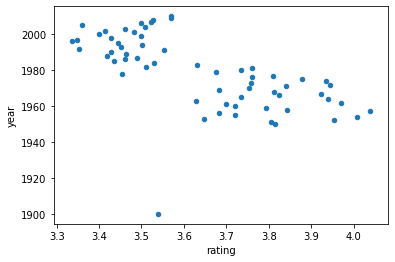

In [40]:
%%time
import pandas as pd
import matplotlib.pyplot as plt

print ('Variant 1 - year before merge')
years_num = list(range(1950,2011))
years = [str(y) for y in years_num]
ratings = pd.read_csv('homework_5_misc\ml-latest-small\/ratings.csv')
names = pd.read_csv('homework_5_misc\ml-latest-small\movies.csv', usecols = ['movieId', 'title'])
def production_year(row):
    for year in years:
        if year in row['title']:
            return int(year)
    return 1900

names['year'] = names.apply(production_year, axis=1)
movies = ratings.merge(names, how = 'left', on = 'movieId')
movies.pivot_table(index = 'year', values = 'rating', aggfunc = 'mean').sort_values('rating', ascending = False).reset_index().plot(kind = 'scatter', x='rating',y='year')

In [32]:
%%time
import pandas as pd
print ('Variant 2 - merge before year')
years_num = list(range(1950,2011))
years = [str(y) for y in years_num]
ratings = pd.read_csv('homework_5_misc\ml-latest-small\/ratings.csv')
names = pd.read_csv('homework_5_misc\ml-latest-small\movies.csv', usecols = ['movieId', 'title'])
def production_year(row):
    for year in years:
        if year in row['title']:
            return int(year)
    return 1900

movies = ratings.merge(names, how = 'left', on = 'movieId')
movies['year'] = movies.apply(production_year, axis=1)
movies.pivot_table(index = 'year', values = 'rating', aggfunc = 'mean').sort_values('rating', ascending = False).head()

Variant 2 - merge before year
Wall time: 1min 36s


,rating
year,
1957,4.039535
1954,4.009191
1962,3.969466
1952,3.953125
1972,3.944293
